### 受限玻尔兹曼机（RBM）原理与代码实现总结
---
#### **一、RBM原理概述**
受限玻尔兹曼机（Restricted Boltzmann Machine）是一种基于能量的概率图模型，由可见层（Visible Layer）和隐层（Hidden Layer）组成，层内无连接，层间全连接。其核心是通过无监督学习学习数据的潜在特征分布。
##### **1. 模型结构**
- **可见层（v）**：输入数据的显式表示（如像素值）。
- **隐层（h）**：提取的潜在特征。
- **权重矩阵（W）**：连接可见层与隐层的权重。
- **偏置**：可见层偏置（b）和隐层偏置（c）。
##### **2. 能量函数与概率分布**
RBM的能量函数定义为：
$$
E(\mathbf{v}, \mathbf{h}) = -\mathbf{v}^T W \mathbf{h} - \mathbf{b}^T \mathbf{v} - \mathbf{c}^T \mathbf{h}
$$
联合概率分布通过玻尔兹曼分布给出：
$$
P(\mathbf{v}, \mathbf{h}) = \frac{ e^{-E(\mathbf{v}, \mathbf{h})} }{Z}
$$
其中 $ Z $ 为配分函数（归一化因子）。可见层的边缘分布为：
$$
P(\mathbf{v}) = \sum_{\mathbf{h}} P(\mathbf{v}, \mathbf{h})
$$
##### **3. 条件独立性**
由于层内无连接，给定可见层时隐层条件独立，反之亦然：
$$
P(h_j=1|\mathbf{v}) = \sigma\left(\sum_i W_{ij} v_i + c_j\right)
$$
$$
P(v_i=1|\mathbf{h}) = \sigma\left(\sum_j W_{ij} h_j + b_i\right)
$$
其中 $\sigma(x) = \frac{1}{1+e^{-x}}$ 为Sigmoid激活函数。
##### **4. 训练目标**
通过最大化似然函数学习参数（W, b, c）。目标函数为负对数似然：
$$
\mathcal{L} = -\sum_{\mathbf{v}} \log P(\mathbf{v})
$$
采用对比散度（CD）算法近似梯度，更新规则为：
$$
\Delta W_{ij} = \epsilon \left(\langle v_i h_j \rangle_{\text{data}} - \langle v_i h_j \rangle_{\text{recon}}\right)
$$
其中 $\epsilon$ 为学习率，$\langle \cdot \rangle_{\text{data}}$ 和 $\langle \cdot \rangle_{\text{recon}}$ 分别为数据分布和重构分布的期望。

---
#### **二、代码内容概括**
代码实现了RBM的训练与可视化，主要包含以下部分：
##### **1. 核心类 `RBMRunner`**
- **功能**：封装RBM训练、数据增强、可视化及评估流程。
- **关键参数**：
  - `n_visible`：可见层单元数（默认64）。
  - `n_components`：隐层单元数（默认256）。
  - `learning_rate`：学习率（默认0.1）。
  - `batch_size`：批大小（默认100）。
  - `n_epochs`：迭代次数（默认30）。
- **设备支持**：自动选择GPU（`cuda`）或CPU。
##### **2. 训练流程 (`fit` 方法)**
- **初始化RBM**：使用 `RestrictedBoltzmannMachine` 定义可见层与隐层维度。
- **优化器**：采用随机梯度下降（SGD）优化参数。
- **训练步骤**：
  1. **正相（Positive Phase）**：计算隐层激活概率 $ P(\mathbf{h}|\mathbf{v}) $。
  2. **负相（Negative Phase）**：通过模拟退火采样器（`SimulatedAnnealingOptimizer`）生成重构样本。
  3. **目标函数**：最小化能量函数加权重衰减（L2正则化）。
  4. **反向传播**：更新权重和偏置。
##### **3. 其他内容**

- **数据加载 (`load_data` 方法)**

    - 数据集：使用 `sklearn.datasets.load_digits`（8x8手写数字图像）。
    - 增强：对原始图像进行上下左右平移，扩展数据集。

- **可视化输出 (设置`plot_img=True`)**

    - 生成样本：展示RBM学习到的数据分布。
    - 权重与梯度：可视化权重矩阵及其梯度变化。


In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import random
import time

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import Pipeline

seed = 42
# PyTorch
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)       # 为当前GPU设置
    torch.cuda.manual_seed_all(seed)   # 为所有GPU设置
# Python
random.seed(seed)
# NumPy
np.random.seed(seed)

[RBM] Pre-training start:
Iteration 1, Average Objective: 0.023579
jmean 0.03867952525615692 jmax 0.12480003386735916
hmean 0.04987050220370293 hmax 0.09960930794477463
Iteration 2, Average Objective: 0.225402
Iteration 3, Average Objective: 0.570877
Iteration 4, Average Objective: 0.650009
Iteration 5, Average Objective: 0.678736
Iteration 6, Average Objective: 0.798165
Iteration 7, Average Objective: 0.817136
Iteration 8, Average Objective: 0.857094
Iteration 9, Average Objective: 0.807875
Iteration 10, Average Objective: 0.913738
Iteration 11, Average Objective: 1.076438
Iteration 12, Average Objective: 1.013771
Iteration 13, Average Objective: 1.142021
Iteration 14, Average Objective: 1.060290
Iteration 15, Average Objective: 0.939937
Iteration 16, Average Objective: 0.769534
Iteration 17, Average Objective: 0.780690
Iteration 18, Average Objective: 0.924694
Iteration 19, Average Objective: 0.743577
Iteration 20, Average Objective: 0.855404
Iteration 21, Average Objective: 0.934497

/Users/chang137/GitHub/myenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


RBM Pipline training completed in 174.93 seconds
Logistic regression training completed in 0.27 seconds

Logistic regression using RBM features:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       188
           1       0.84      0.86      0.85       183
           2       0.90      0.90      0.90       172
           3       0.88      0.86      0.87       205
           4       0.94      0.91      0.92       168
           5       0.86      0.85      0.86       183
           6       0.94      0.97      0.95       183
           7       0.91      0.95      0.93       189
           8       0.80      0.78      0.79       160
           9       0.81      0.81      0.81       166

    accuracy                           0.89      1797
   macro avg       0.88      0.88      0.88      1797
weighted avg       0.89      0.89      0.89      1797


Test Accuracy: 0.8865

Logistic regression using raw pixel features:
              precision   

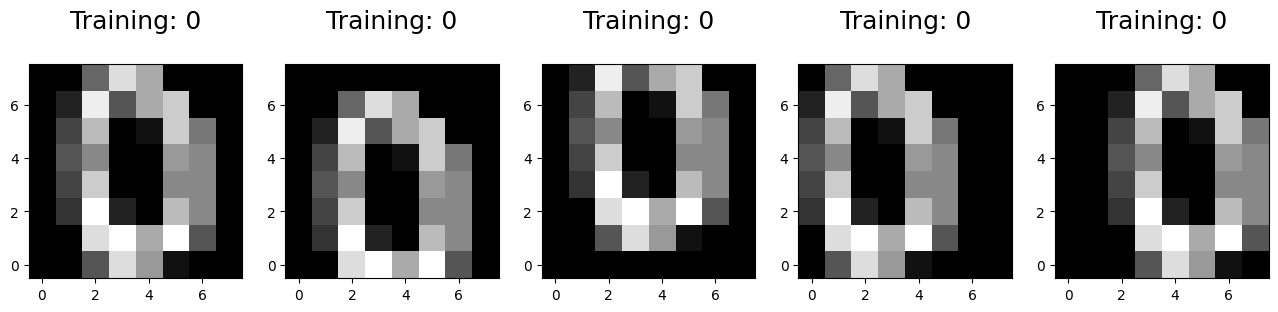

In [2]:
from rbm_digits import  RBMRunner
import kaiwu as kw
# 添加license相关信息
# kw.license.init(user_id="", sdk_code="")

logistic = LogisticRegression(random_state=seed)

# 初始化RBM
rbm = RBMRunner(
    n_visible=8*8,
    n_components=128, 
    learning_rate=0.1, 
    batch_size=32, 
    n_epochs=2, 
    verbose=True, 
    plot_img=False,
    random_state=seed
)

#加载数据
X_train, X_test, y_train, y_test = rbm.load_data(plot_img=True)

classifier = Pipeline(steps=[('rbm', rbm),
                             ('logistic', logistic)])

########## 训练模型 ##########
logistic.C = 500.0
logistic.max_iter = 1000

# 训练 RBM-Logistic Pipeline
start_time = time.time()
classifier.fit(X_train, y_train)
training_time = time.time() - start_time
print(f"RBM Pipline training completed in {training_time:.2f} seconds")

# 训练 Logistic regression
logistic_classifier = LogisticRegression(C=500.0, max_iter=1000, random_state=seed)

start_time = time.time()
logistic_classifier.fit(X_train, y_train)
training_time = time.time() - start_time
print(f"Logistic regression training completed in {training_time:.2f} seconds")

########## 评估模型 ##########
pip_pred = classifier.predict(X_test)
pip_acc = accuracy_score(y_test, pip_pred)
print("\nLogistic regression using RBM features:\n%s\n" % (
    classification_report(
        y_test,
        pip_pred)))
print(f"Test Accuracy: {pip_acc:.4f}")   

log_pred = logistic_classifier.predict(X_test)
log_acc = accuracy_score(y_test, log_pred)
print("\nLogistic regression using raw pixel features:\n%s\n" % (
    classification_report(
        y_test,
        log_pred)))
print(f"Test Accuracy: {log_acc:.4f}")

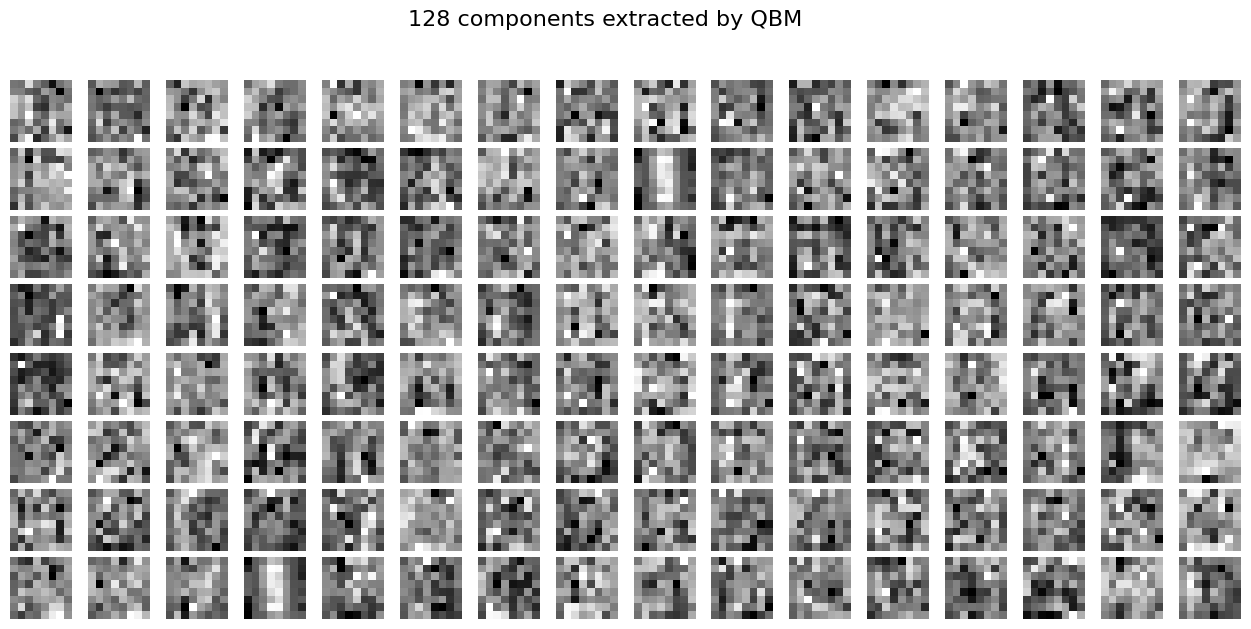

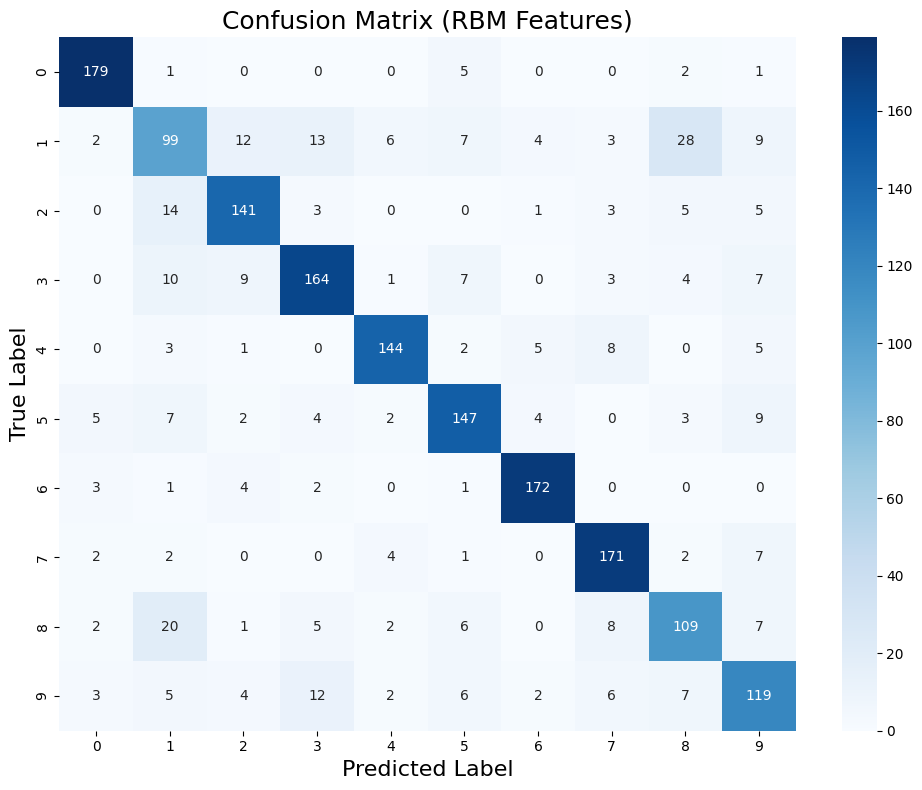

In [3]:
# 绘制权重
rbm.plot_weights(rbm, save_pdf=False)

# 绘制混淆矩阵
rbm.plot_confusion_matrix(y_test, log_pred, title_suffix="RBM Features", save_pdf=False)